In [1]:
%matplotlib inline
import collections
import pathlib
import pickle

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.max_open_warning'] = 0
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.size'] = 12

In [2]:
def cluster(l, key, threshold):
    clusters = []
    cluster = []
    for x in sorted(l, key=key):
        if not cluster or key(x) - key(cluster[-1]) <= threshold:
            cluster.append(x)
        else:
            clusters.append(cluster)
            cluster = []
    if cluster:
        clusters.append(cluster)
    return clusters

f_axis = np.fft.fftshift(np.fft.fftfreq(2048, 1/40.96)) + 1575.42

def read_spectrum(f, skip=10):
    dtype = 'float32' if 'power' in f.name else 'complex64'
    x = np.fromfile(f, dtype)
    x = x.reshape((-1, 2048))[skip:]
    return np.average(x, axis=0)

def read_spectra(f):
    f0 = f.name.replace('power_0', '')
    return np.stack([read_spectrum(f.parent / (f0 + chan))
                     for chan in ['power_0', 'power_1', 'cross_0',
                                  'power_2', 'power_3', 'cross_5']])

def best_spectra(fs):
    x = np.array([read_spectrum(f) for f in fs])
    a = np.argmax(np.sum(x, axis=1))
    return read_spectra(fs[a])

In [3]:
compute_spectra = False
spectra_file = '/home/destevez/ata_notebooks/polarimetry/GPS/spectra.pickle'

if compute_spectra:
    days = ('2', '3', '4')
    files = [f for d in days for f in
             pathlib.Path('/mnt/buf0/').glob(f'GPS*2021-06-0{d}*5b-2j_power_0')]
    data = {f: (f.name.split('_')[0][:-1].replace('---', ' ').replace('--', ' '),
                np.datetime64(f.name.split('_')[1]))
            for f in files}

    sats = {d[0] for d in data.values()}
    sat_files = {s: [(f, v[1]) for f, v in data.items() if v[0] == s]
                 for s in sats}
    
    sat_clusters = {s: cluster(v, key=lambda x: x[1],
                               threshold=np.timedelta64(3600, 's'))
                    for s, v in sat_files.items()}

    clusters = [(s, a[0][1], [b[0] for b in a])
                 for s, v in sat_clusters.items() for a in v]
    
    spectra = collections.defaultdict(list)
    for c in sorted(clusters, key=lambda x: x[1]):
        satellite = c[0]
        spectra[satellite].append((best_spectra(c[2]), c[1]))
    spectra = dict(spectra)
    with open(spectra_file, 'wb') as f:
        pickle.dump(spectra, f)
else:
    with open(spectra_file, 'rb') as f:
        spectra = pickle.load(f)

In [4]:
spectra_avg = np.average(np.stack([s[0] for ss in spectra.values() for s in ss]),
                         axis=0)

In [5]:
def calibrate_RHCP(xcorrs):
    gains = 1 / np.sqrt(xcorrs[[0, 1, 3, 4]].real)
    phases = 1j * np.exp(-1j * np.angle(xcorrs[[2, 5]]))
    return np.array([
        gains[0]**2, gains[1]**2, gains[0]*gains[1]*phases[0],
        gains[2]**2, gains[3]**2, gains[2]*gains[3]*phases[1],
    ])

In [6]:
def stokes(x):
    return 0.25*np.array([(x[0] + x[1] + x[3] + x[4]).real,
                         (x[0] - x[1] + x[3] - x[4]).real,
                         (2*x[2] + 2*x[5]).real,
                         -(2*x[2] + 2*x[5]).imag])

In [7]:
N = spectra_avg.shape[1]
cal0 = calibrate_RHCP(np.average(spectra_avg[:, N//4:3*N//4], axis=1))
cal0 = cal0[:, np.newaxis]
I0 = stokes(cal0 * spectra_avg)[0]
cal = np.stack([calibrate_RHCP(s) for s in (spectra_avg/I0).T], axis=1)

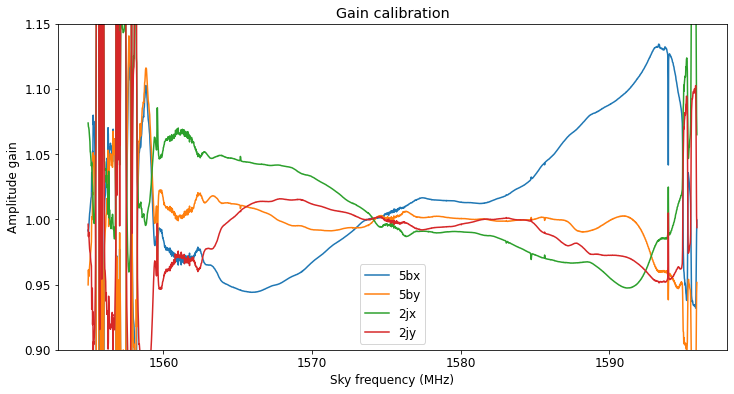

In [8]:
for j in (0, 1, 3, 4):
    plt.plot(f_axis, np.abs(np.sqrt(cal[j]/cal0[j])))
plt.ylim((0.9, 1.15))
plt.title('Gain calibration')
plt.xlabel('Sky frequency (MHz)')
plt.ylabel('Amplitude gain')
plt.legend(['5bx', '5by', '2jx', '2jy']);

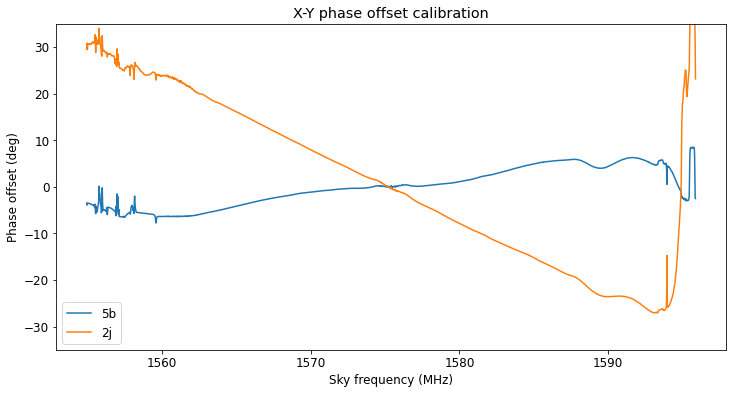

In [9]:
for j in (2, 5):
    plt.plot(f_axis, np.rad2deg(np.angle(cal[j]/cal0[j])))
plt.ylim((-35, 35))
plt.title('X-Y phase offset calibration')
plt.xlabel('Sky frequency (MHz)')
plt.ylabel('Phase offset (deg)')
plt.legend(['5b', '2j']);

In [14]:
def sortGPS(name):
    _, gen, sv = name.split(' ')[0].split('-')
    gens = ['BIIR', 'BIIRM', 'BIIF', 'BIII']
    return gens.index(gen), int(sv)

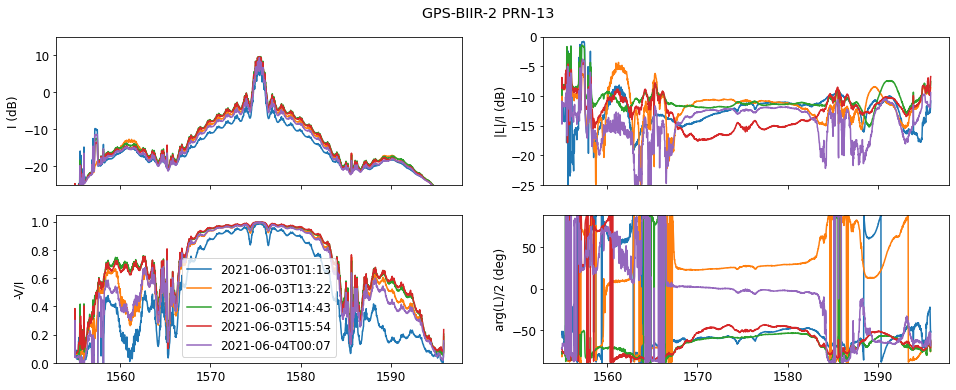

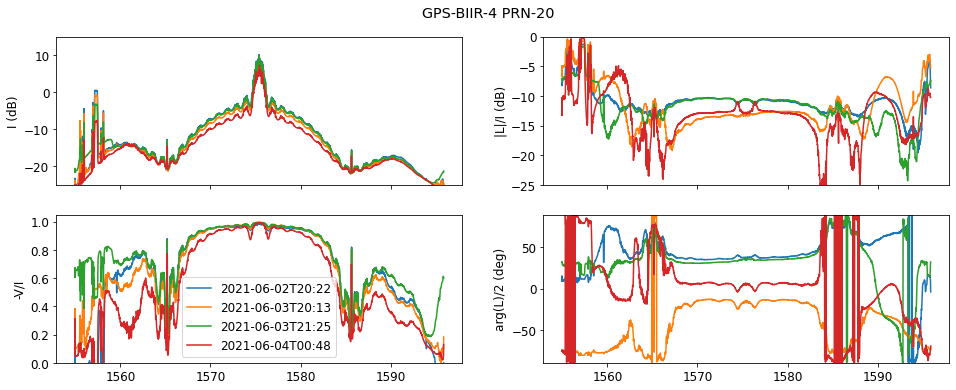

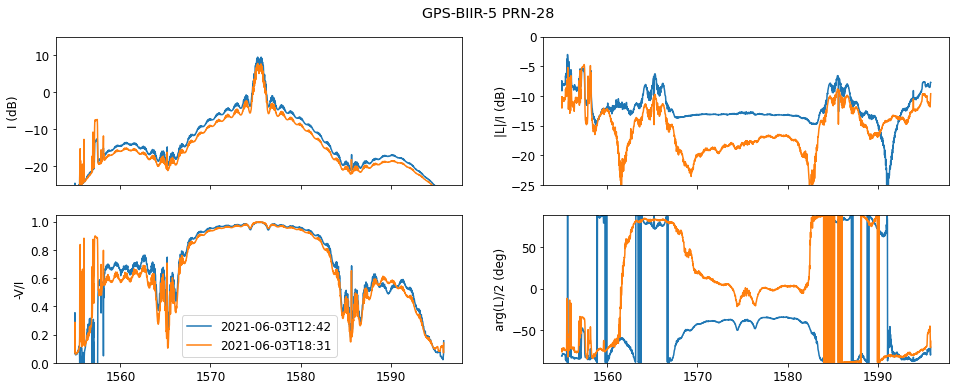

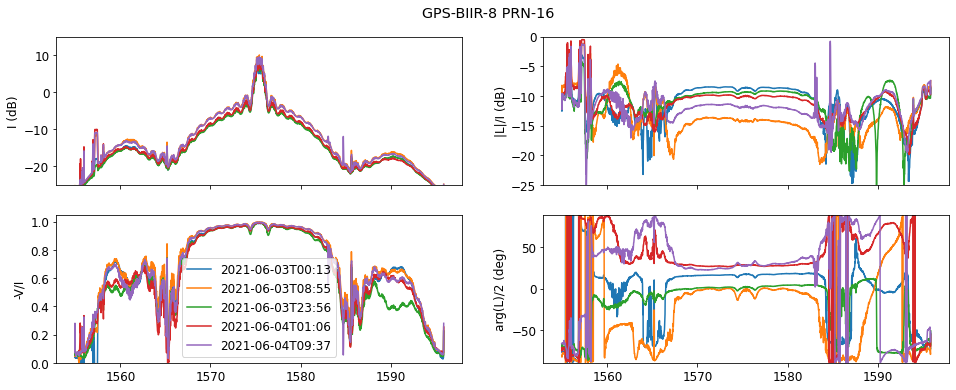

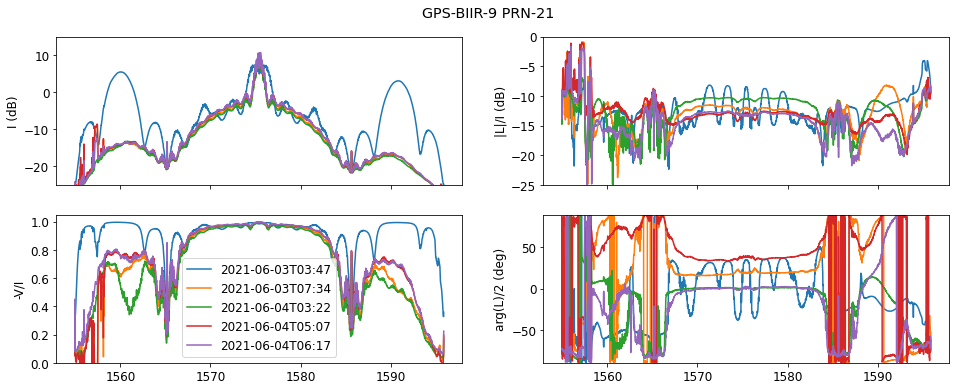

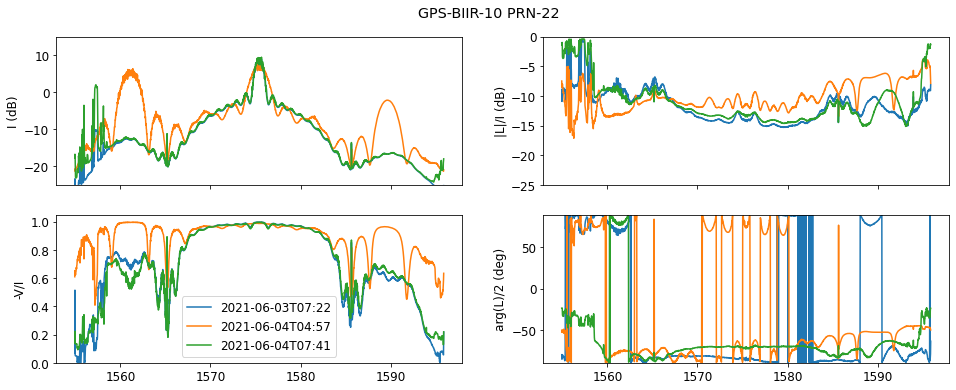

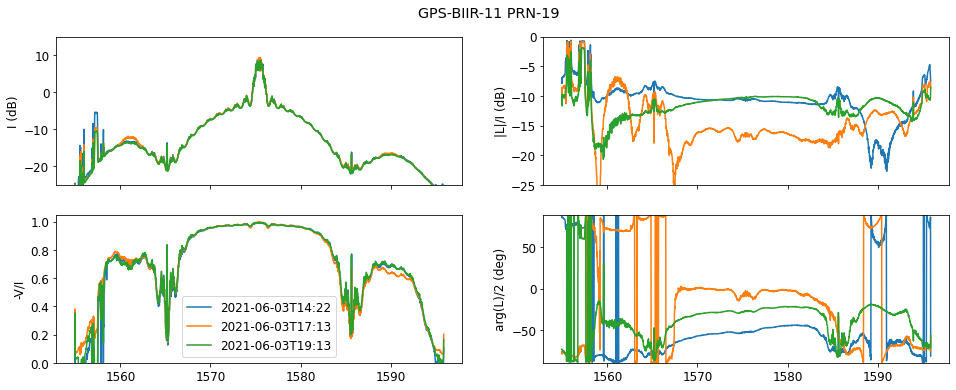

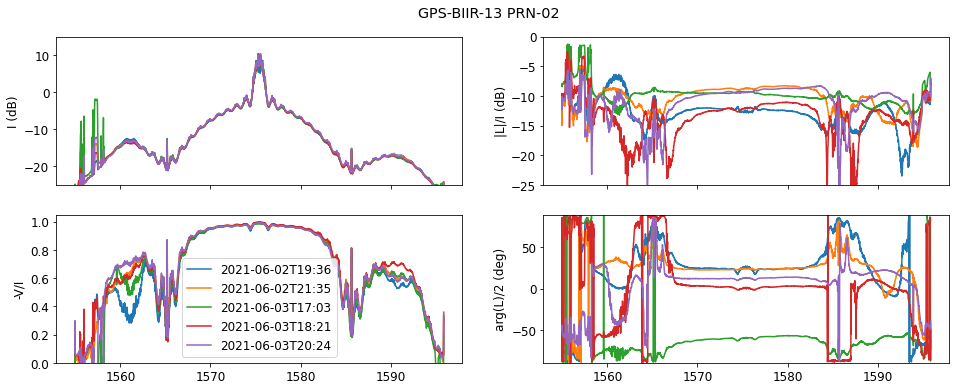

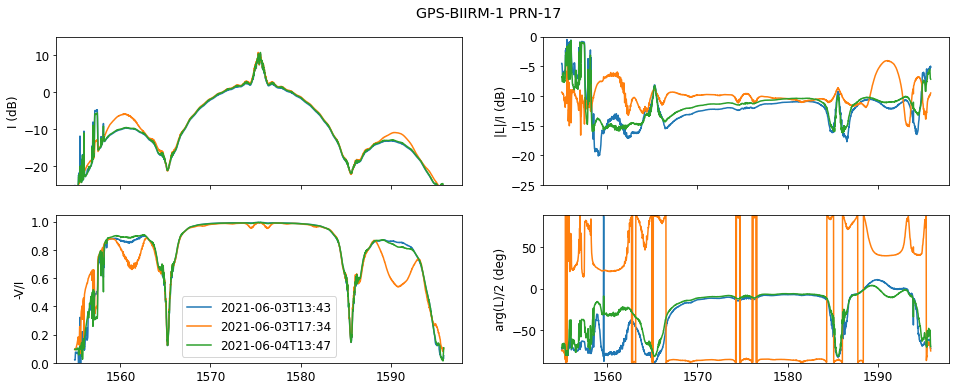

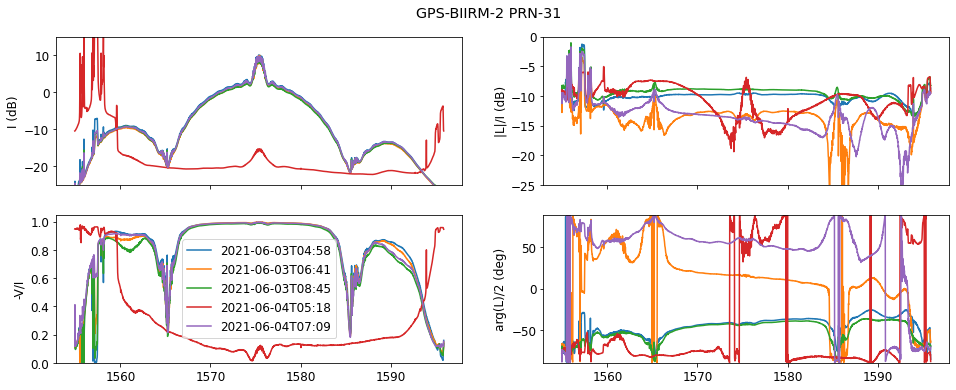

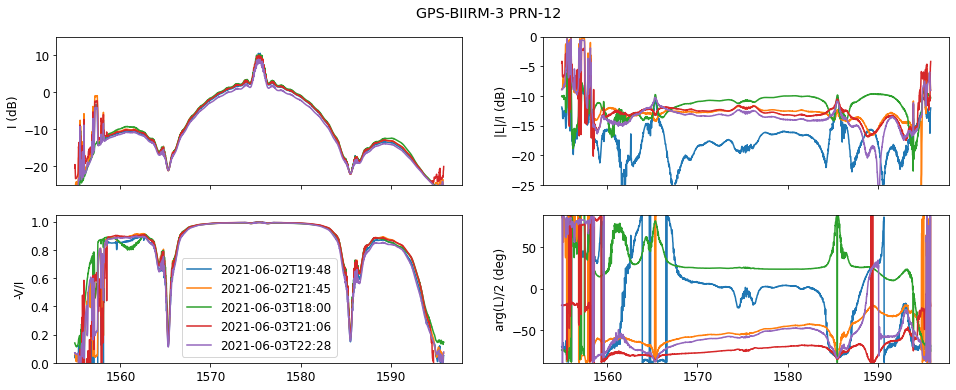

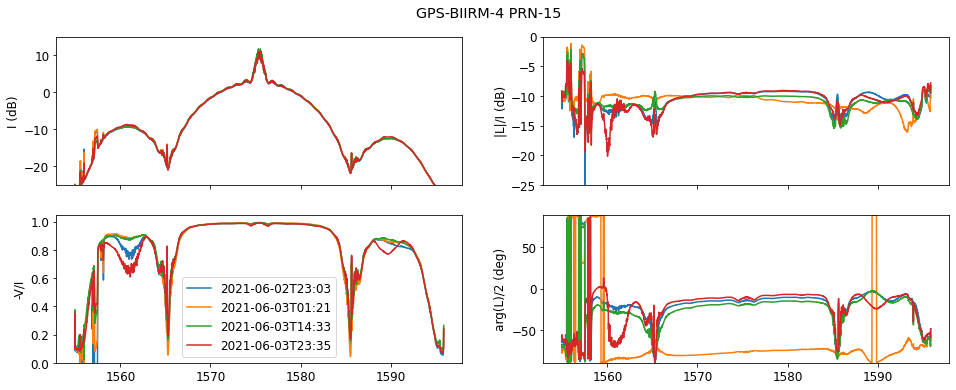

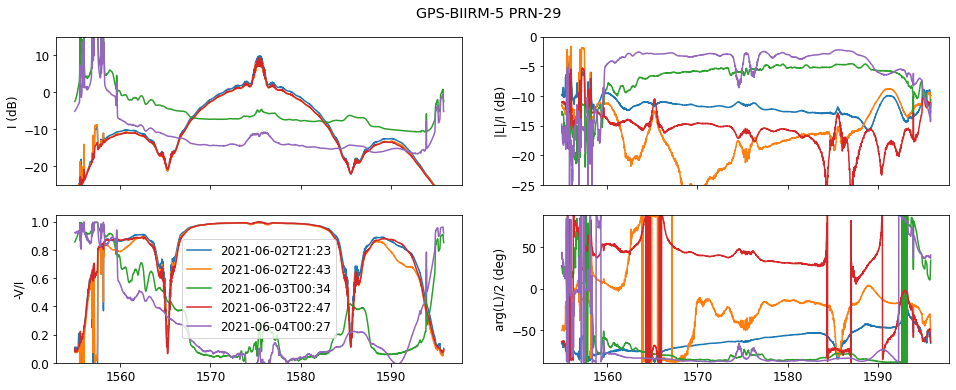

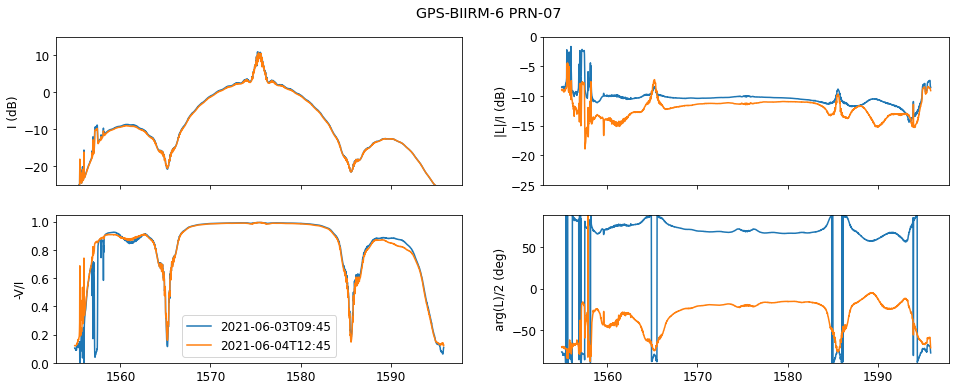

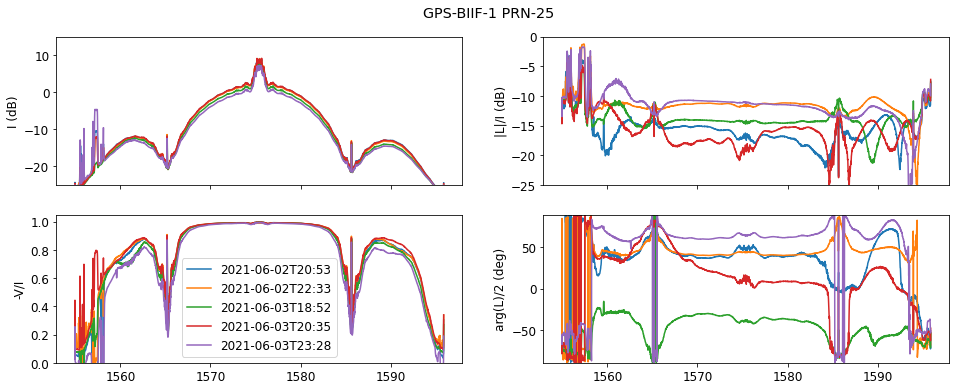

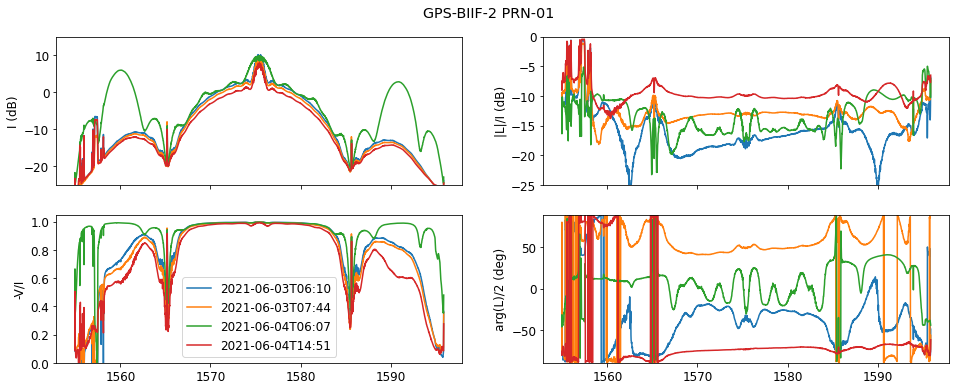

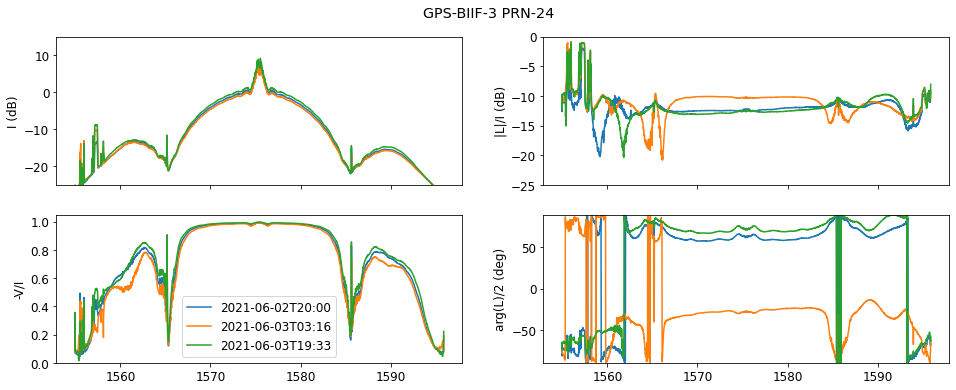

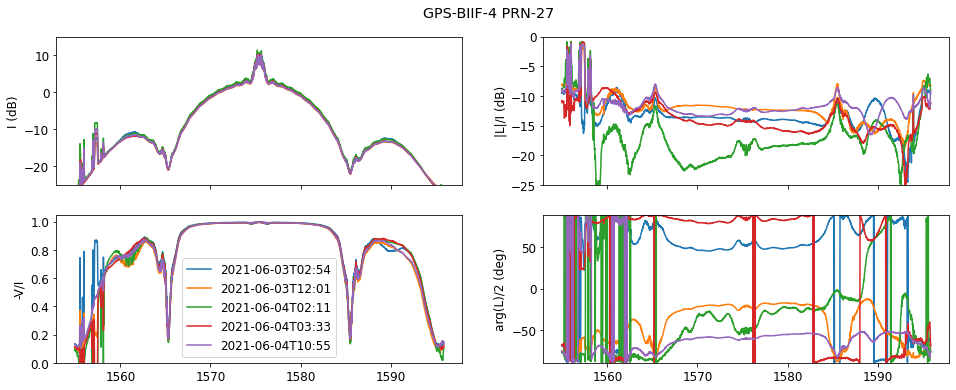

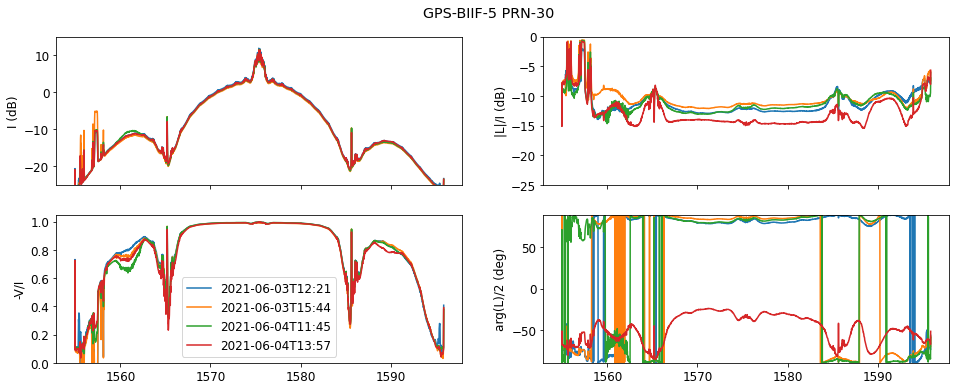

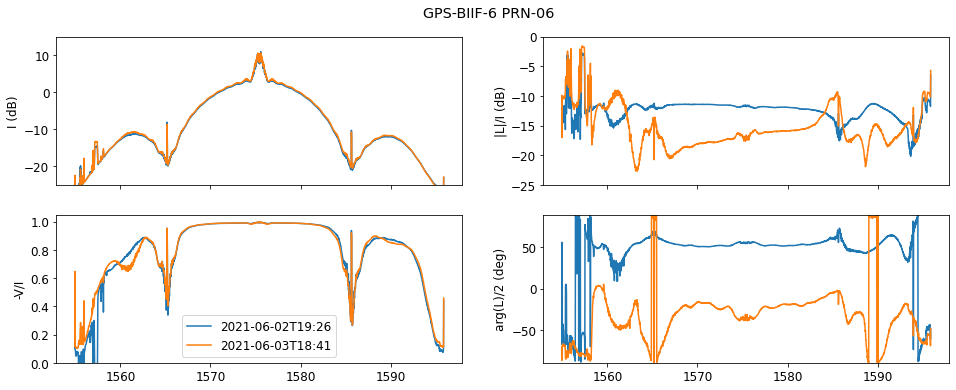

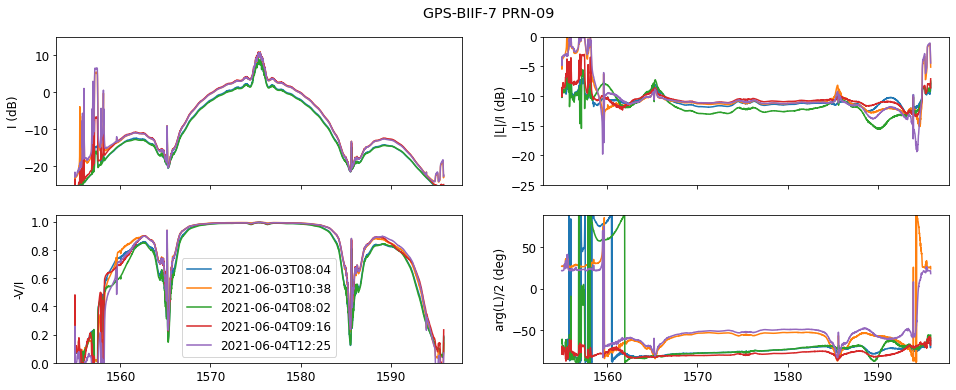

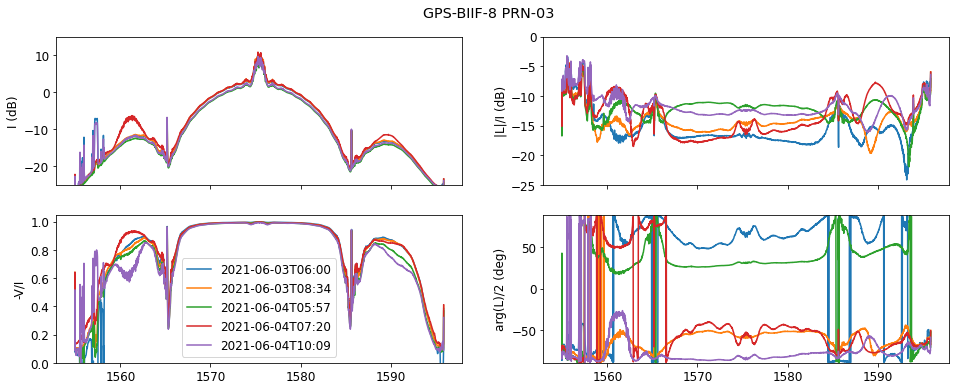

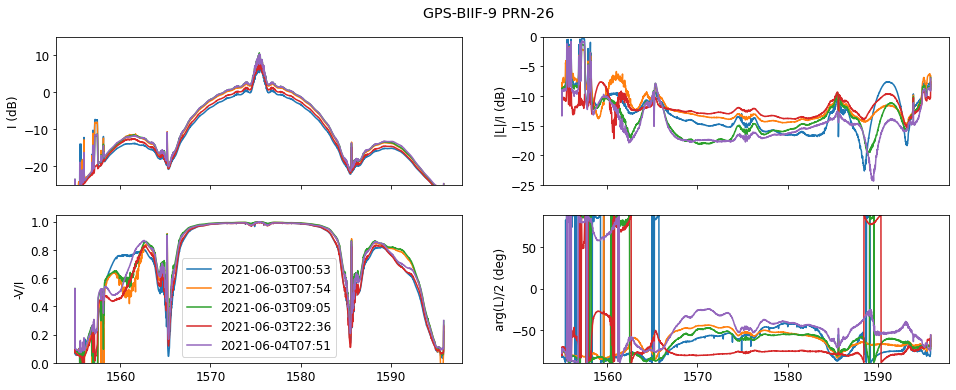

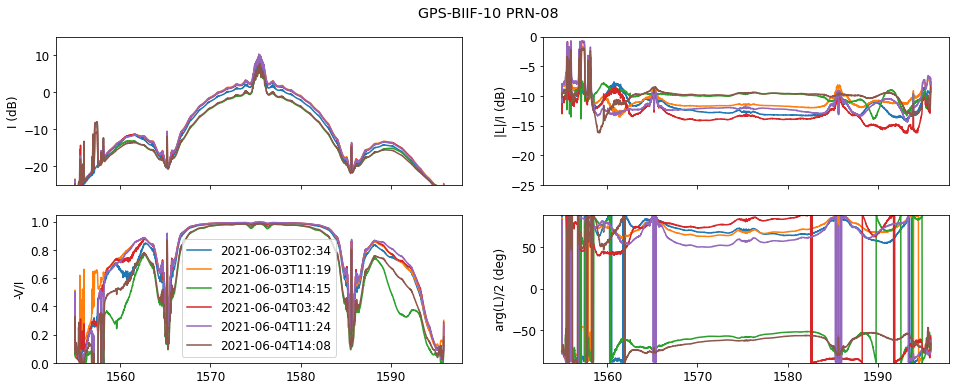

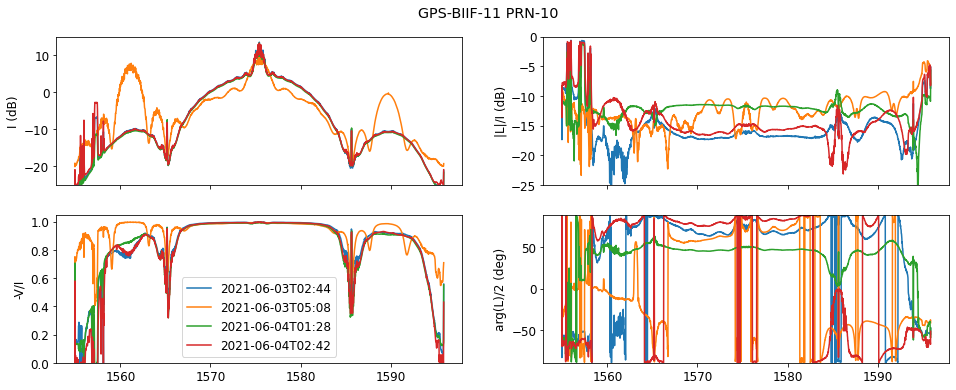

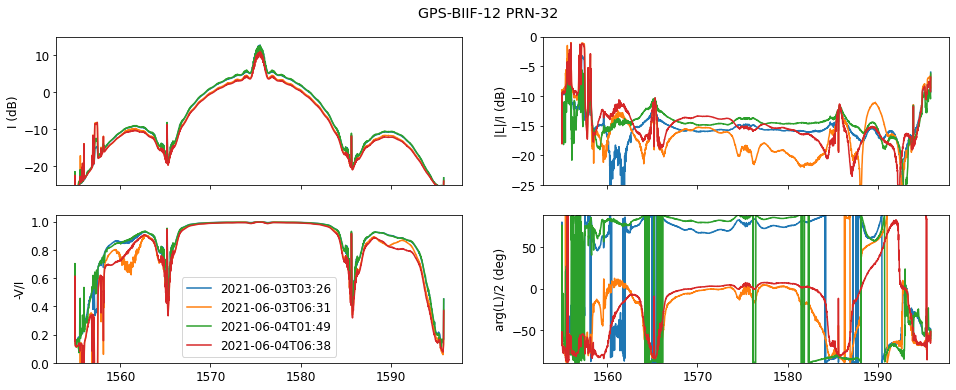

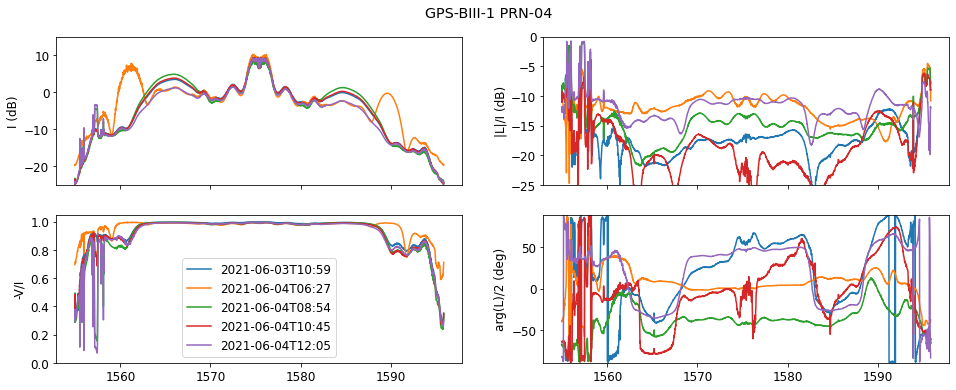

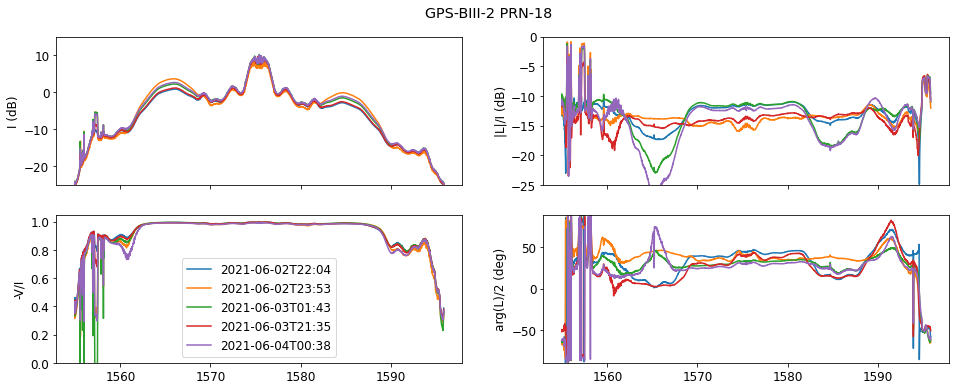

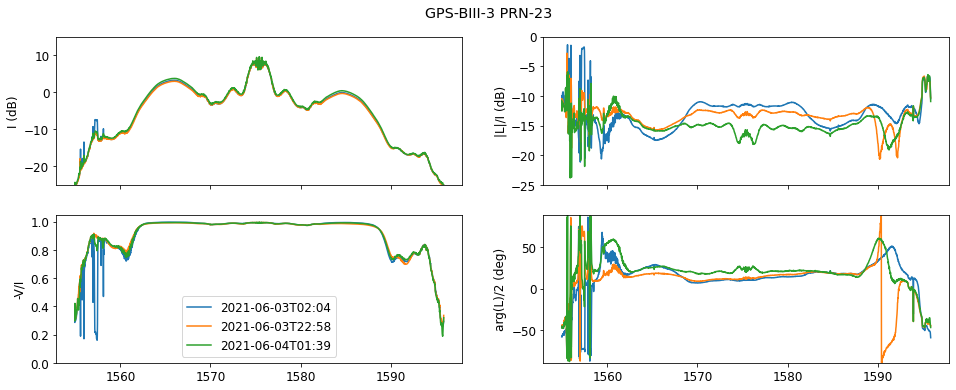

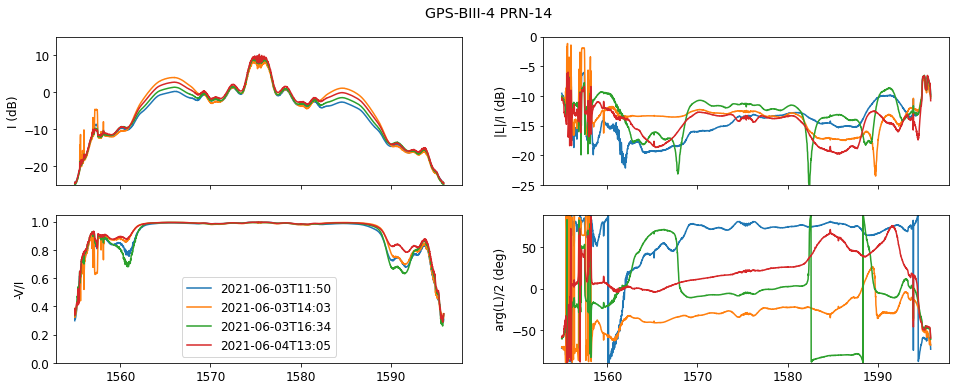

In [15]:
for k in sorted(spectra, key=sortGPS):
    fig, axs = plt.subplots(2, 2, figsize=(16,6), sharex=True)
    for j, y in enumerate(spectra[k]):
        x, label = y
        S = stokes(cal * x)
        label = str(label).split('.')[0][:-3]
        color = f'C{j}'
        kwargs = {'label': label, 'color': color}
        axs[0, 0].plot(f_axis, 10*np.log10(S[0]), **kwargs)
        axs[1, 0].plot(f_axis, -S[3]/S[0], **kwargs)
        axs[1, 0].set_ylim((0, 1.05))
        axs[0, 0].set_ylim((-25, 15))
        axs[0, 1].plot(f_axis,
                       10*np.log10(np.abs(S[1] + 1j*S[2])) - 10*np.log10(S[0]),
                       **kwargs)
        axs[1, 1].plot(f_axis,
                       0.5*np.rad2deg(np.angle(S[1] + 1j*S[2])), **kwargs)
        axs[0, 1].set_ylim((-25, 0))
        axs[1, 1].set_ylim((-90, 90))
        axs[0, 0].set_ylabel('I (dB)')
        axs[1, 0].set_ylabel('-V/I')
        axs[0, 1].set_ylabel('|L|/I (dB)')
        axs[1, 1].set_ylabel('arg(L)/2 (deg)')
    fig.suptitle(k, y=0.95)
    axs[1, 0].legend()